# Unsere Quellen zum Visualisierungserfolg:
### Wie Wähle ich die richtige Visualisierung?

https://eazybi.com/blog/data_visualization_and_chart_types/

### Wo finde ich sie in Python?

https://python-graph-gallery.com

# Domänenwissen

* Öffnungszeiten (Theater, Uni)
* Peak Times, Tag
* Ferienzeiten
* Special Events (Demos, Strassensperren)
* Parkplätze kostenlos/bezahlt?
* Sonntag Flohmarkt

# Ideen
* Vergleich mit Wetterdaten
* Verlgeich mit Öffis -> Empfehlungen aussprechen -> z.B. mehr Busse sollen fahren, aber eine U-Bahn kann ausfallen
* Anhand von hauptsächlich Fußgänger könnte man behaupten, wann Vorlesungen auf der TU sind

# Korrelation
* Wie viele fahren rein um bestimmte Uhrzeit rein -> Belegung Parkplätze
* WiFi Nutzung in Zusammenhang mit parkenden Autos?

# Prädiktionen (ML)
* Traffic-/Personenaufkommen zu bestimmten Tageszeiten

# Distribution
* Normalverteilung

# Intervall
* Tageszeiten
* Wochen

# Fragen flow.lab
* Wie wurden Pedestrian Daten aufgenommen?
* Was sind die Daten bei WiFi?
* Gibt es schon Ergebnisse aus Wettbewerb?
* Gibt es neue Daten?
* Erklärung zu Datenset?

### Erklärungen/Links zu wichtigen Libraries
- Markdown schreiben hier in Jupyter: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
- folium für map Visualisierungen: https://github.com/python-visualization/folium

In [8]:
# get default size onboard
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.rcParams['figure.dpi'] = 200

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins
from IPython.display import HTML
import sklearn as sk
import numpy as np
import datetime
from datetime import timedelta
import json

Populating the interactive namespace from numpy and matplotlib


# Unsere Mission.

<img src="images/logo_tu.png" alt="logo TU" style="width: 200px;"/>

<img src="images/logo_berlin_cisco.png" alt="logo berlin cisco" style="width: 200px;"/>

<img src="images/foto_verkehr.png" alt="foto verkehr" style="width: 800px;"/>


# Sensoren der Senatsverwaltung im Flow Projekt

![Sensor_Locations](images/Sensor_Locations.jpg)

# Sensoren Visualisierungstool  🔮

### Daten einlesen
> Erns-Reuter-Platz Datensatz aus http://flow.dai-labor.de

In [9]:
wifi = pd.read_csv('data/wifi.csv')
parking = pd.read_csv('data/parking.csv', delimiter=' ')

In [10]:
# TODO: alle Typen aus der metadata.json in Python Variablen, z.B.:
campus_eb = [52.512388, 13.32360925]
campus_tel = [52.51298775, 13.32029525]
ernst_reuter_platz_center = [52.512611, 13.321856]

# TODO: json daten auslesen
metadata = json.loads(open('data/metadata.json').read())

wifi_latlon = metadata['wifi']['latlon']
pedestrian_latlon = metadata['pedestrian']['latlon']
traffic_latlon = metadata['traffic']['latlon']
parking_latlon = metadata['parking']['latlon']

# Parking

In [11]:
## TODO: take center of ernst-reuter platz as location=POINT
map = folium.Map(location=ernst_reuter_platz_center, zoom_start=17)


for key in wifi_latlon:
    folium.Circle(
        radius=50,
        location=wifi_latlon[key],
        popup=key,
        color='#3186cc',
        fill=True
    ).add_to(map)
    
for key in pedestrian_latlon:
    folium.Marker(
        location=pedestrian_latlon[key],
        popup=key,
        icon=folium.Icon(icon='info-sign')
    ).add_to(map)
    
for key in traffic_latlon:
    folium.Marker(
        location=traffic_latlon[key],
        popup=key,
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_to(map)

for key in parking_latlon:
    folium.Circle(
        radius=2,
        location=parking_latlon[key],
        popup=key,
        color='red',
        fill=True
    ).add_to(map)

map

In [12]:
parking['Time'] = pd.to_datetime(parking['Timestamp'], unit='ms')
parking['Weekday'] = parking['Time'].dt.dayofweek
parking['Hour'] = parking['Time'].dt.hour
parking = parking.sort_values(by=['Timestamp'])

mon = 0
tue = 0
wed = 0
thu = 0
fri = 0
sat = 0
sun = 0

def weekday_parking(weekday, fromTime, toTime):
    if weekday != -1:
        day_parking = parking[parking['Weekday'] == weekday]
    else:
        day_parking = parking.copy()
        
    day_parking = day_parking[day_parking['Hour'] >= fromTime]
    day_parking = day_parking[day_parking['Hour'] <= toTime]

    start = float(day_parking[['Timestamp']].iloc[0])
    end = float(day_parking[['Timestamp']].iloc[-1])
    startDayTime = day_parking[['Time']].iloc[0].dt
    endDayTime = day_parking[['Time']].iloc[-1].dt
    
    lastTime = startDayTime
    
    totalDays = 1

    for index, row in day_parking.iterrows():
        if (int(row['Time'].day) != int(lastTime.day)):
            lastTime = row['Time']
            totalDays+=1
            

    totalTime = timedelta(days=totalDays)
    totalTime -= timedelta(hours=int(startDayTime.hour))
    totalTime -= timedelta(hours=(24 - int(endDayTime.hour)))
    totalTime -= timedelta(hours=totalDays*fromTime)
    totalTime -= timedelta(hours=totalDays*(24-toTime))
    
    mean_weekday_parking = {}
    
    for key in parking_latlon:
        temp = day_parking[day_parking['ParkingSpotID'] == key][['Timestamp','Occupied','Time']]
        if len(temp) > 0:
            occupied = temp.iloc[0]['Occupied'] == 1
            lastTime = start
            lastDayTime = startDayTime
            mean_weekday_parking[key] = 0

            for index, row in temp.iterrows():
                ##cut off when the day switches
                if (int(row['Time'].day) != int(lastDayTime.day)):
                    if occupied:
                        ##add time till the end of the day
                        endOfDay = timedelta(hours=(24-int(lastDayTime.hour)))
                        mean_weekday_parking[key] += (endOfDay.total_seconds() * 1000)

                    lastTime = row['Timestamp']
                    lastDayTime = row['Time']
                    occupied = row['Occupied'] == 1
                else:
                    if occupied != (row['Occupied'] == 1):
                        if occupied:
                            mean_weekday_parking[key] += row['Timestamp'] - lastTime
                        else:
                            lastTime = row['Timestamp']
                        occupied = row['Occupied'] == 1

            if occupied:
                mean_weekday_parking[key] += end - lastTime

            mean_weekday_parking[key] /= (totalTime.total_seconds() * 1000)
            
            if mean_weekday_parking[key] > 1:
                mean_weekday_parking[key] = 1
            ##print(key, ":", mean_weekday_parking[key])
    
    return mean_weekday_parking;


def show_parking(data):
    parkplatz_center = [52.513025, 13.319505]
    parking_map = folium.Map(location=parkplatz_center, zoom_start=18)

    for key in parking_latlon:
        if key in data:
            visual = data[key]
            folium.Circle(
                radius=1,
                location=parking_latlon[key],
                popup=key + ": " + str(int(visual*100)) + "%",
                color='#%02x%02x%02x' % (int(255 * (1-visual)),int(255 * (1-visual)), int(255 * (1-visual))),
                fill=True
            ).add_to(parking_map)
    return parking_map;
 

## schwarz = häufig belegt, weiß = weniger häufig belegt
# TODO: Prozente 
show_parking(weekday_parking(-1, 6, 22))

In [13]:
show_parking(weekday_parking(3, 6, 22))

In [14]:
show_parking(weekday_parking(6, 6, 22))

In [15]:
show_parking(weekday_parking(-1, 6, 14))

In [16]:
show_parking(weekday_parking(-1, 14, 22))

# Traffic

## Pedestrians

In [17]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.rcParams['figure.dpi'] = 200

Populating the interactive namespace from numpy and matplotlib


### Get a sense of the data

In [18]:
df_pedestrians_original = pd.read_csv('data/pedestrian_counts_tel_a.csv', sep=" ")
print('Total number of entries: \n\n' + str(df_pedestrians_original.count()))
print('\n\nExample Output: ')
df_pedestrians_original.head()

Total number of entries: 

StationIdentifier    402616
Timestamp            402616
Direction            402616
Count                402616
dtype: int64


Example Output: 


,StationIdentifier,Timestamp,Direction,Count
0,CounterVorplatzGeb-AF2-PeopleCounter,1515525300416,IN,0
1,CounterVorplatzGeb-AF2-PeopleCounter,1515525300418,OUT,0
2,CounterHaupteingang-TEL4-PeopleCounter,1515525300417,IN,0
3,CounterHaupteingang-TEL4-PeopleCounter,1515525300415,OUT,0
4,CounterVorplatzGeb-AF2-PeopleCounter,1515525360372,IN,0


### Clean

In [19]:
# clone for backup
df_pedestrians = df_pedestrians_original
# rename
df_pedestrians = df_pedestrians.replace({'CounterVorplatzGeb-AF2-PeopleCounter':'af_counter', 'CounterHaupteingang-TEL4-PeopleCounter':'telekom_counter'})
# drop zero counts
df_pedestrians = df_pedestrians[df_pedestrians.Count != 0]
# timestamp to python data type
df_pedestrians['Timestamp'] = pd.to_datetime(df_pedestrians['Timestamp'].astype(int), unit='ms')

### Verify Dataset Integrity

In [20]:
df_pedestrians_IN = df_pedestrians[df_pedestrians['Direction'] == 'IN'] 
df_pedestrians_OUT = df_pedestrians[df_pedestrians['Direction'] == 'OUT']

In [21]:
df_pedestrians_IN_af = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'af_counter']
df_pedestrians_OUT_af = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'af_counter']
df_pedestrians_IN_tel = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'telekom_counter']
df_pedestrians_OUT_tel = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'telekom_counter']

count_total_IN_records = df_pedestrians_IN['Count'].count()
count_total_OUT_records = df_pedestrians_OUT['Count'].count()
count_walked_IN_af = df_pedestrians_IN_af.Count.sum()
count_walked_OUT_af = df_pedestrians_OUT_af.Count.sum()
count_walked_IN_tel = df_pedestrians_IN_tel.Count.sum()
count_walked_OUT_tel = df_pedestrians_OUT_tel.Count.sum()

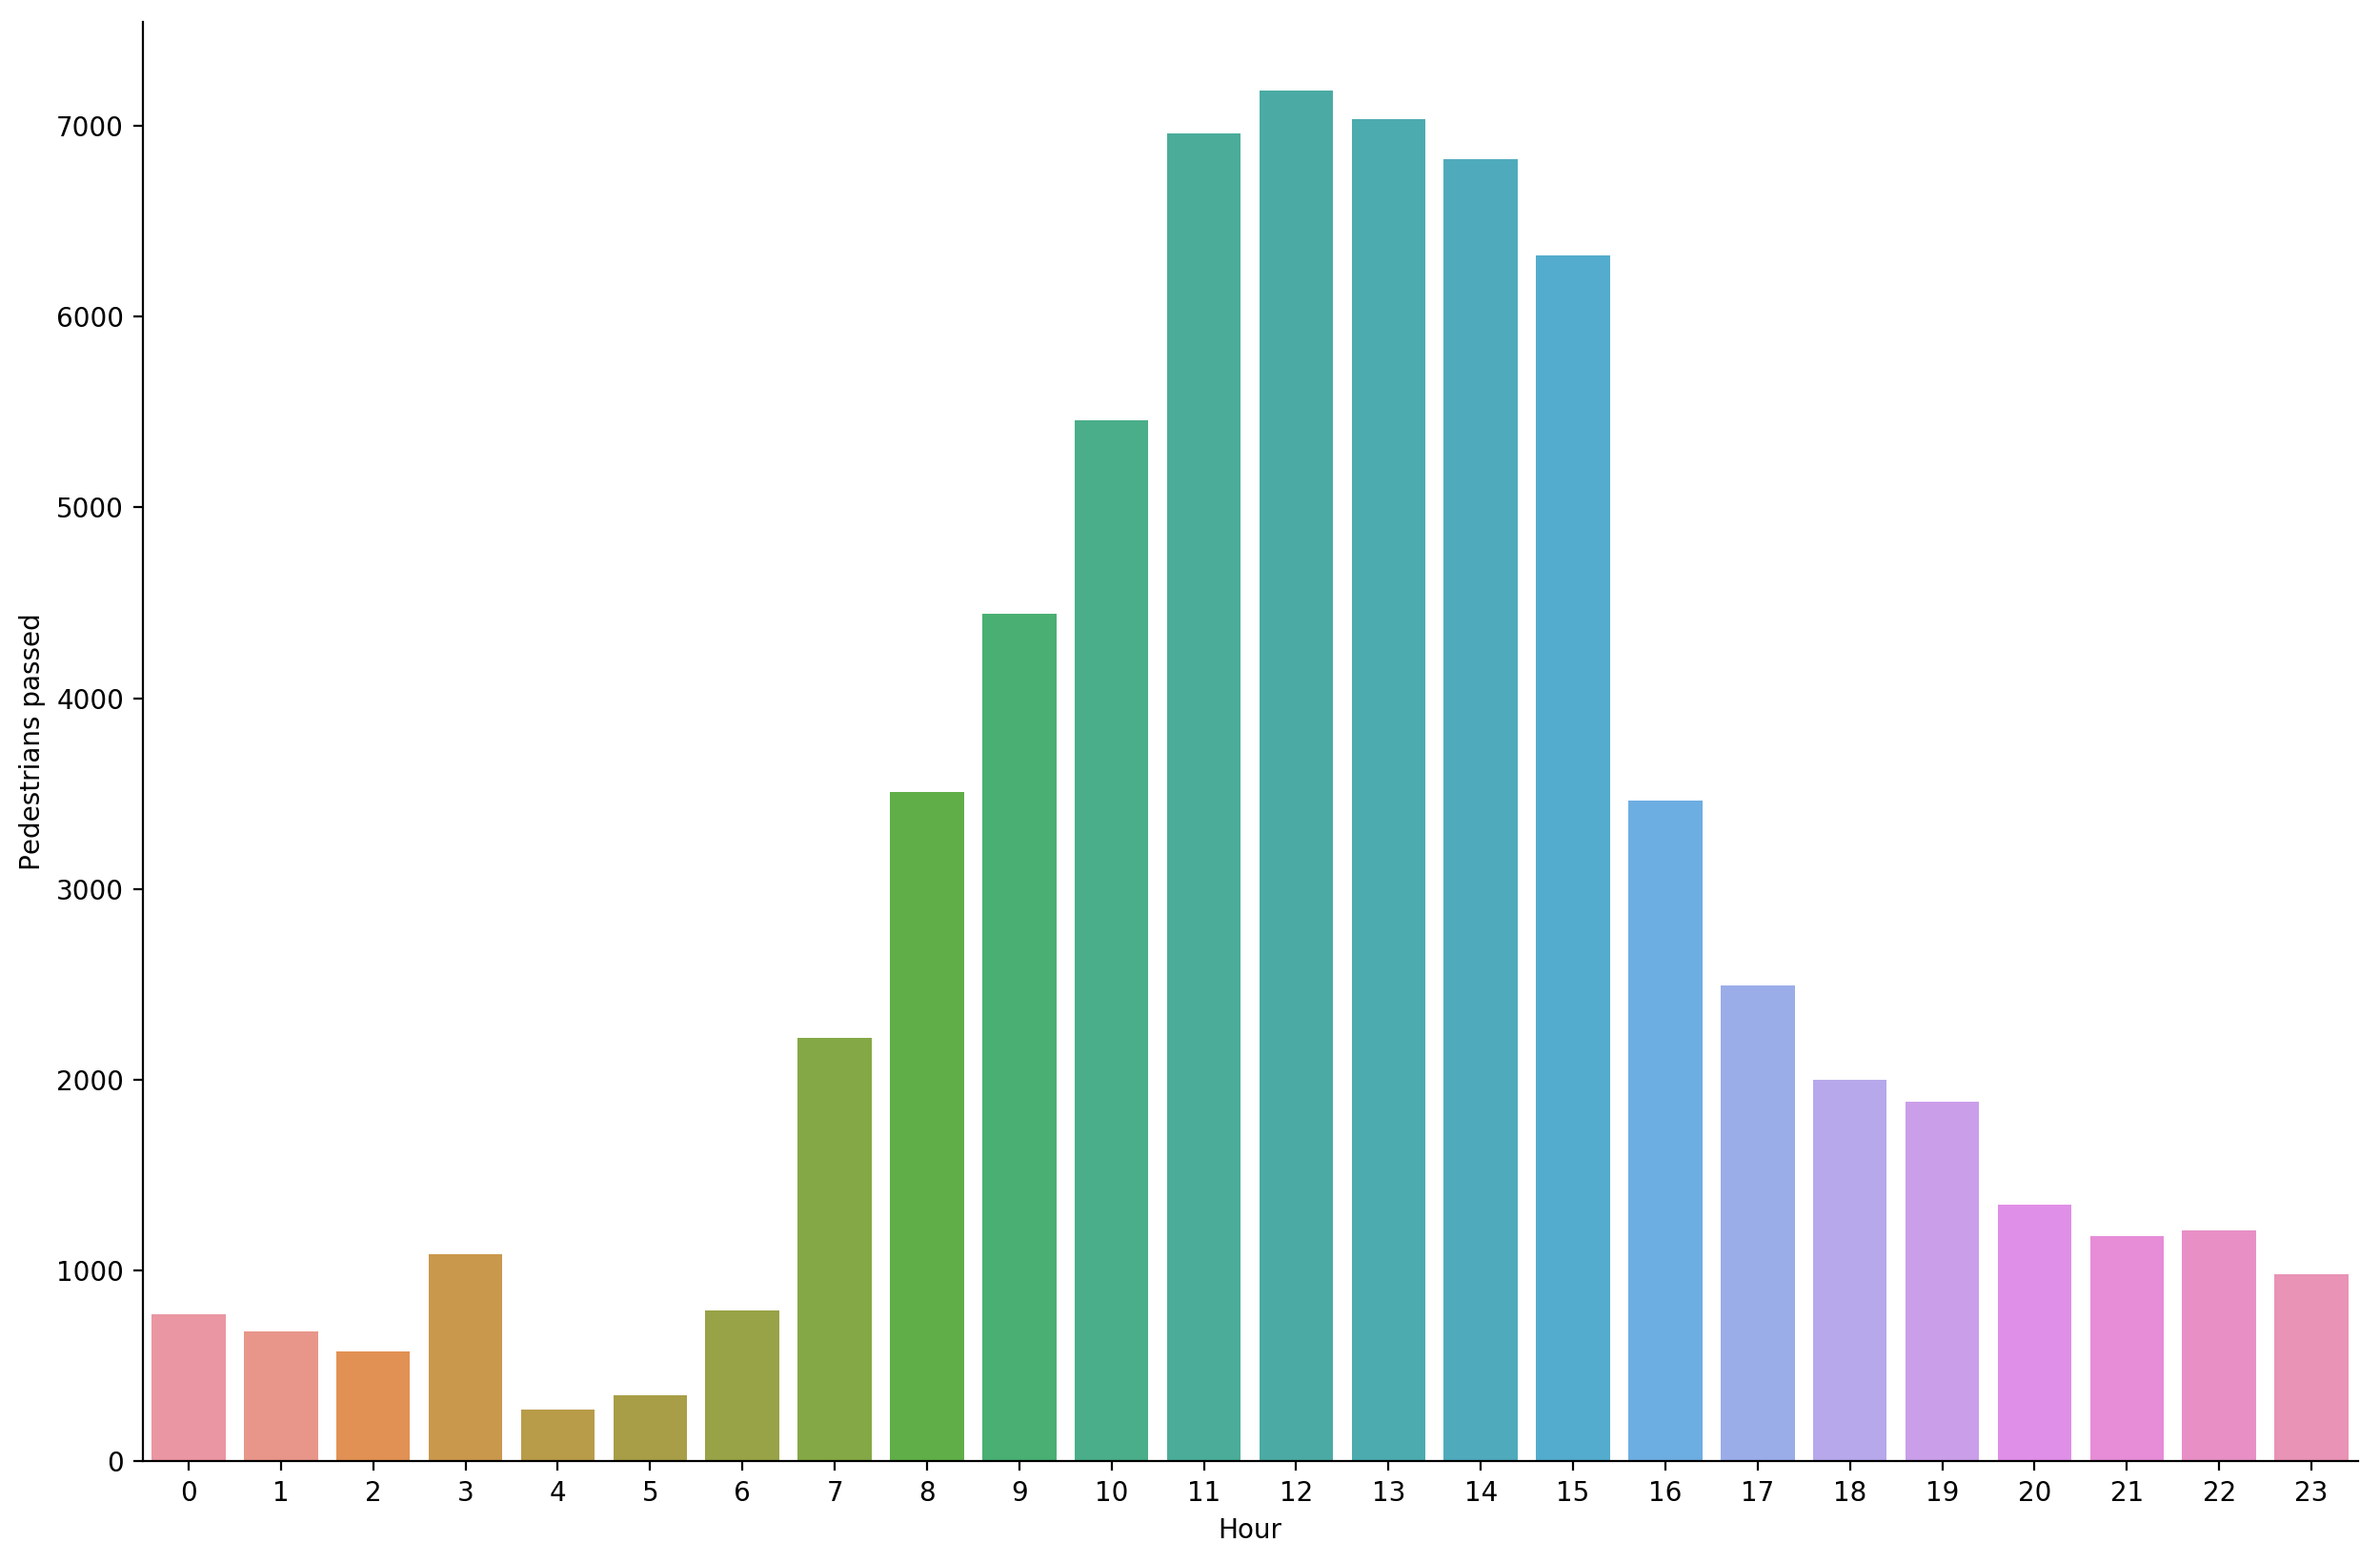

In [22]:
times = pd.DatetimeIndex(df_pedestrians.Timestamp)
grouped = df_pedestrians.groupby([times.hour])
grouped_direction_count = grouped['Direction'].count()

hist_in_out_pedestrians = sns.barplot(x=grouped_direction_count.index, y=grouped_direction_count.values)
hist_in_out_pedestrians.set(xlabel='Hour', ylabel='Pedestrians passed')

sns.distplot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

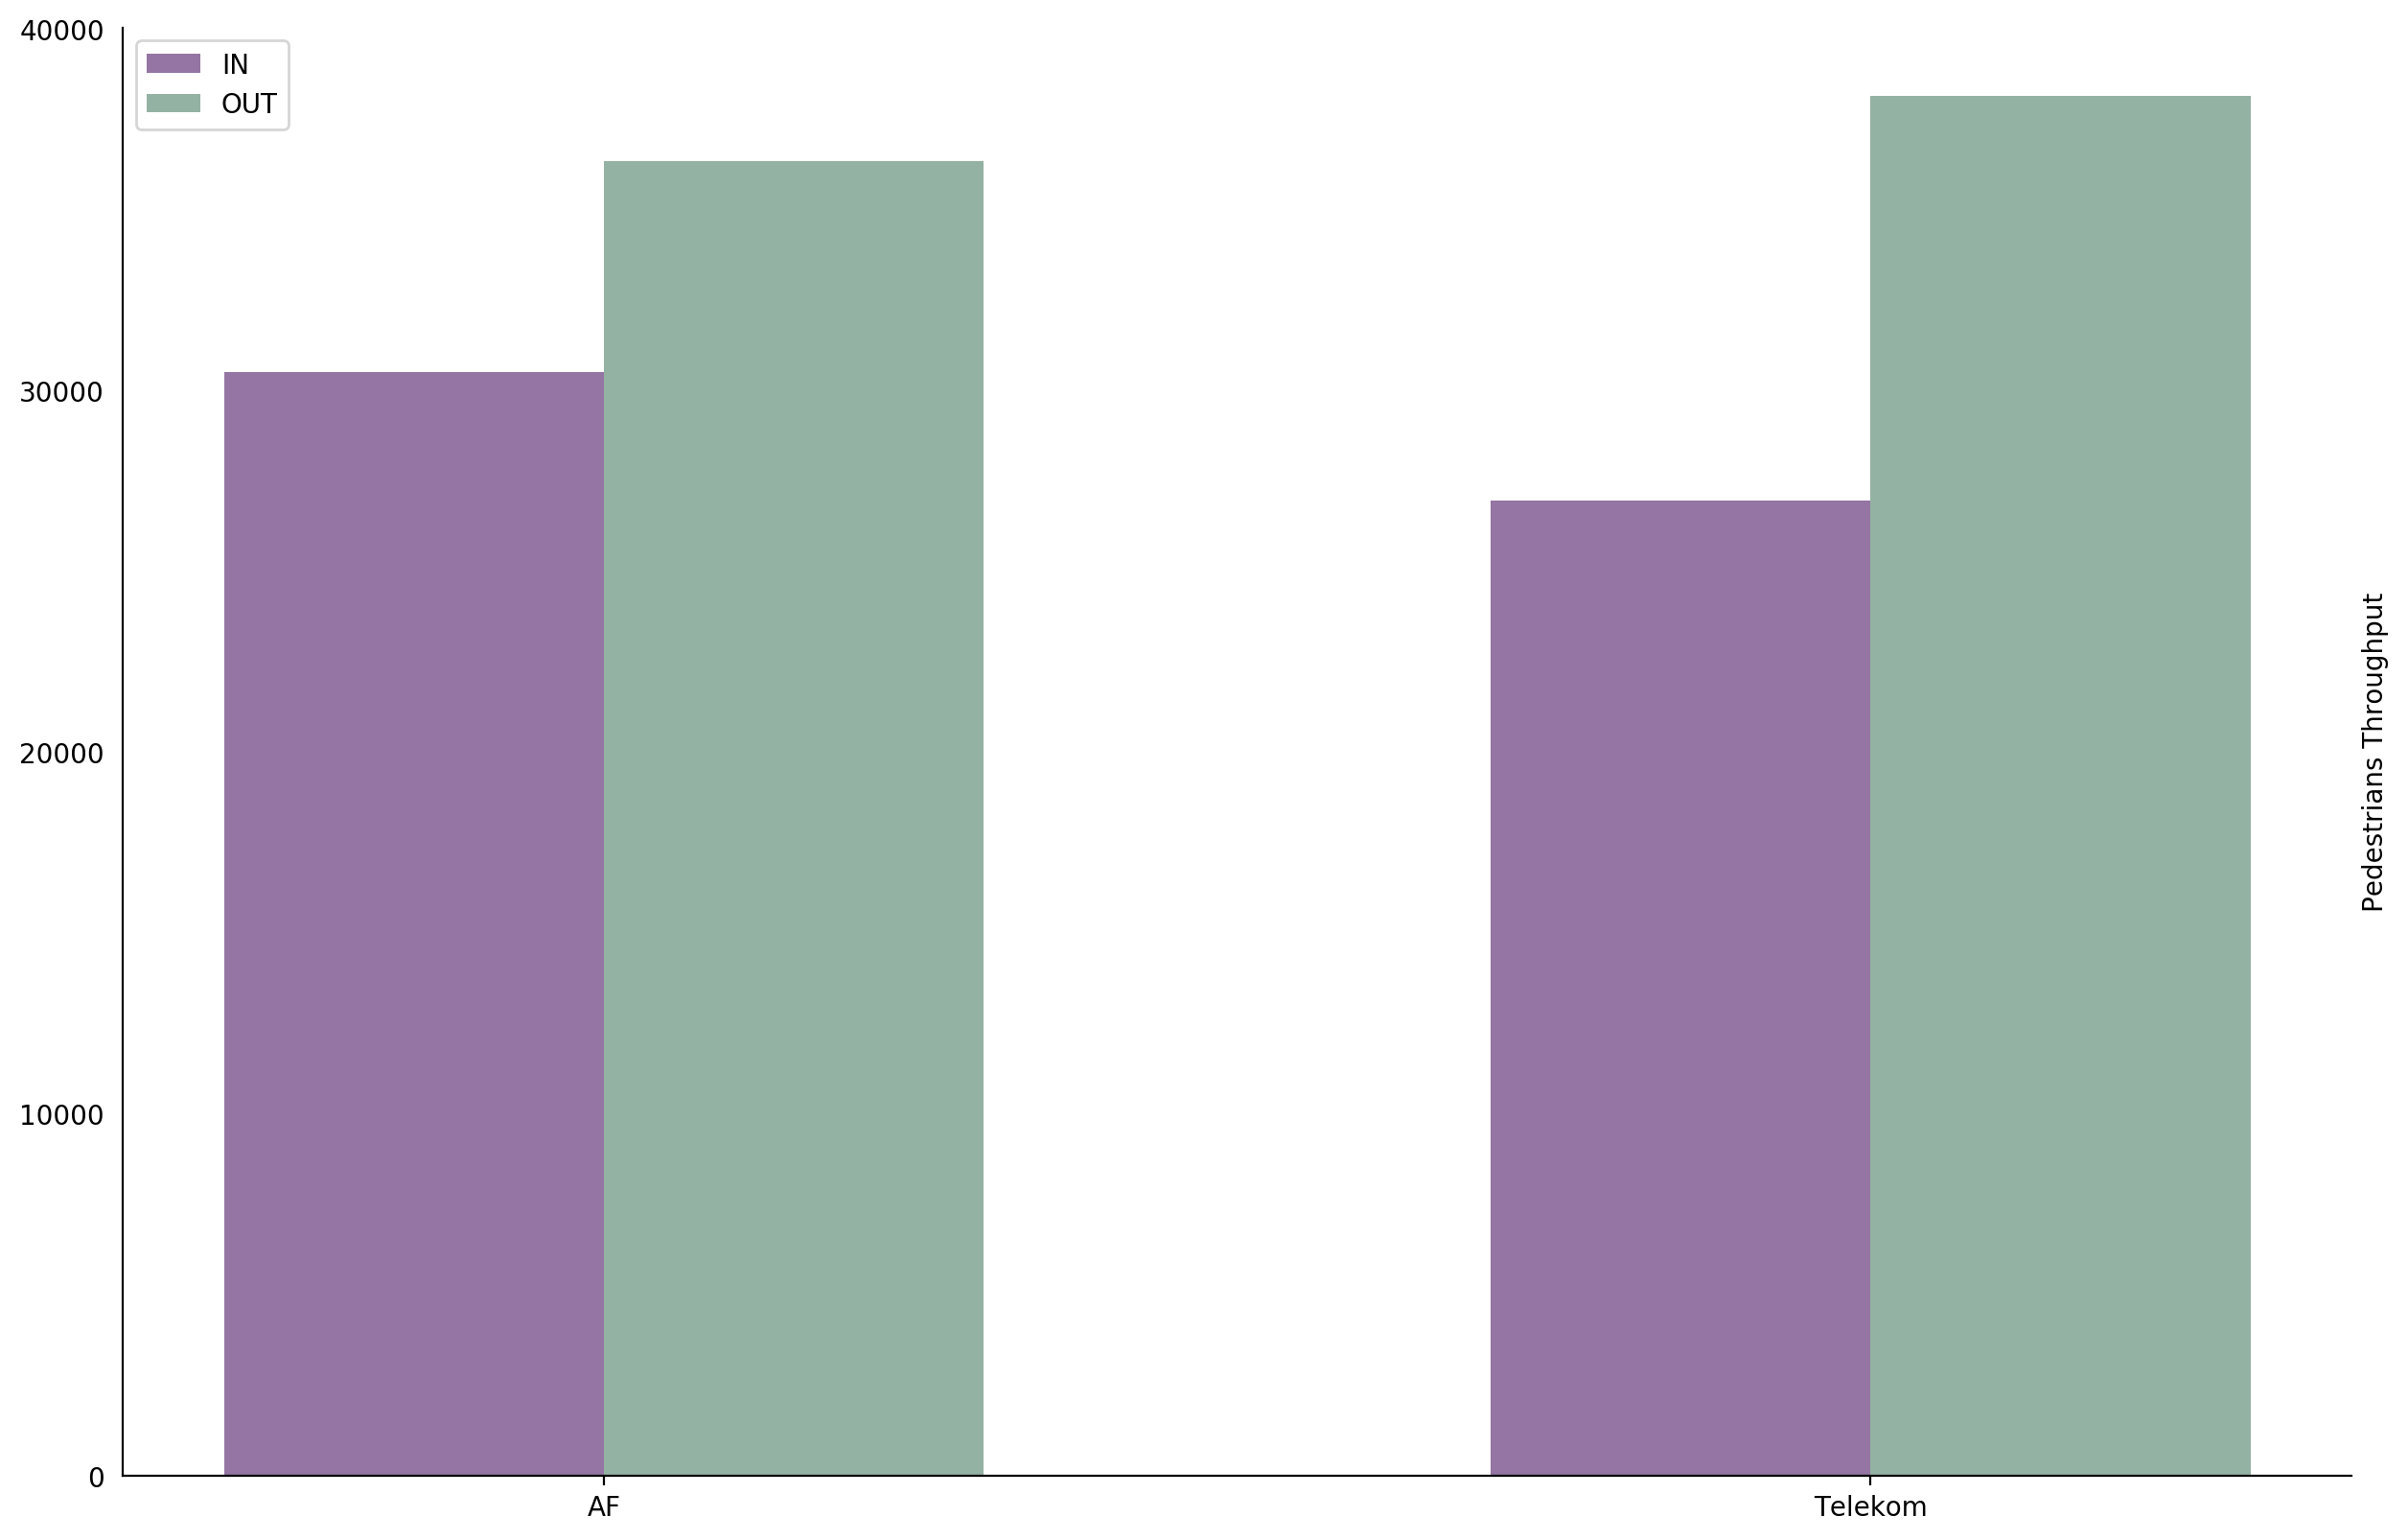

In [23]:
# as bar chart
bar_width = 0.3
bars1 = [count_walked_IN_af, count_walked_IN_tel]
bars2 = [count_walked_OUT_af, count_walked_OUT_tel]
# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + bar_width for x in r1]
# create bars1
plt.bar(r1, bars1, width=bar_width, color=(0.3,0.1,0.4,0.6), capsize=7, label='IN')
plt.bar(r2, bars2, width=bar_width, color=(0.3,0.5,0.4,0.6), capsize=7, label='OUT')

# general layout
plt.xticks([0.15, 1.15], ['AF', 'Telekom'])
plt.ylabel('Pedestrians Throughput')
plt.gca().yaxis.set_label_position("right")
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show graphic
plt.show()

In [24]:
print('The buildings must be spawning pedestrians from the cellar 😱🧙')
print('Or there might be different entries to the building...')

The buildings must be spawning pedestrians from the cellar 😱🧙
Or there might be different entries to the building...


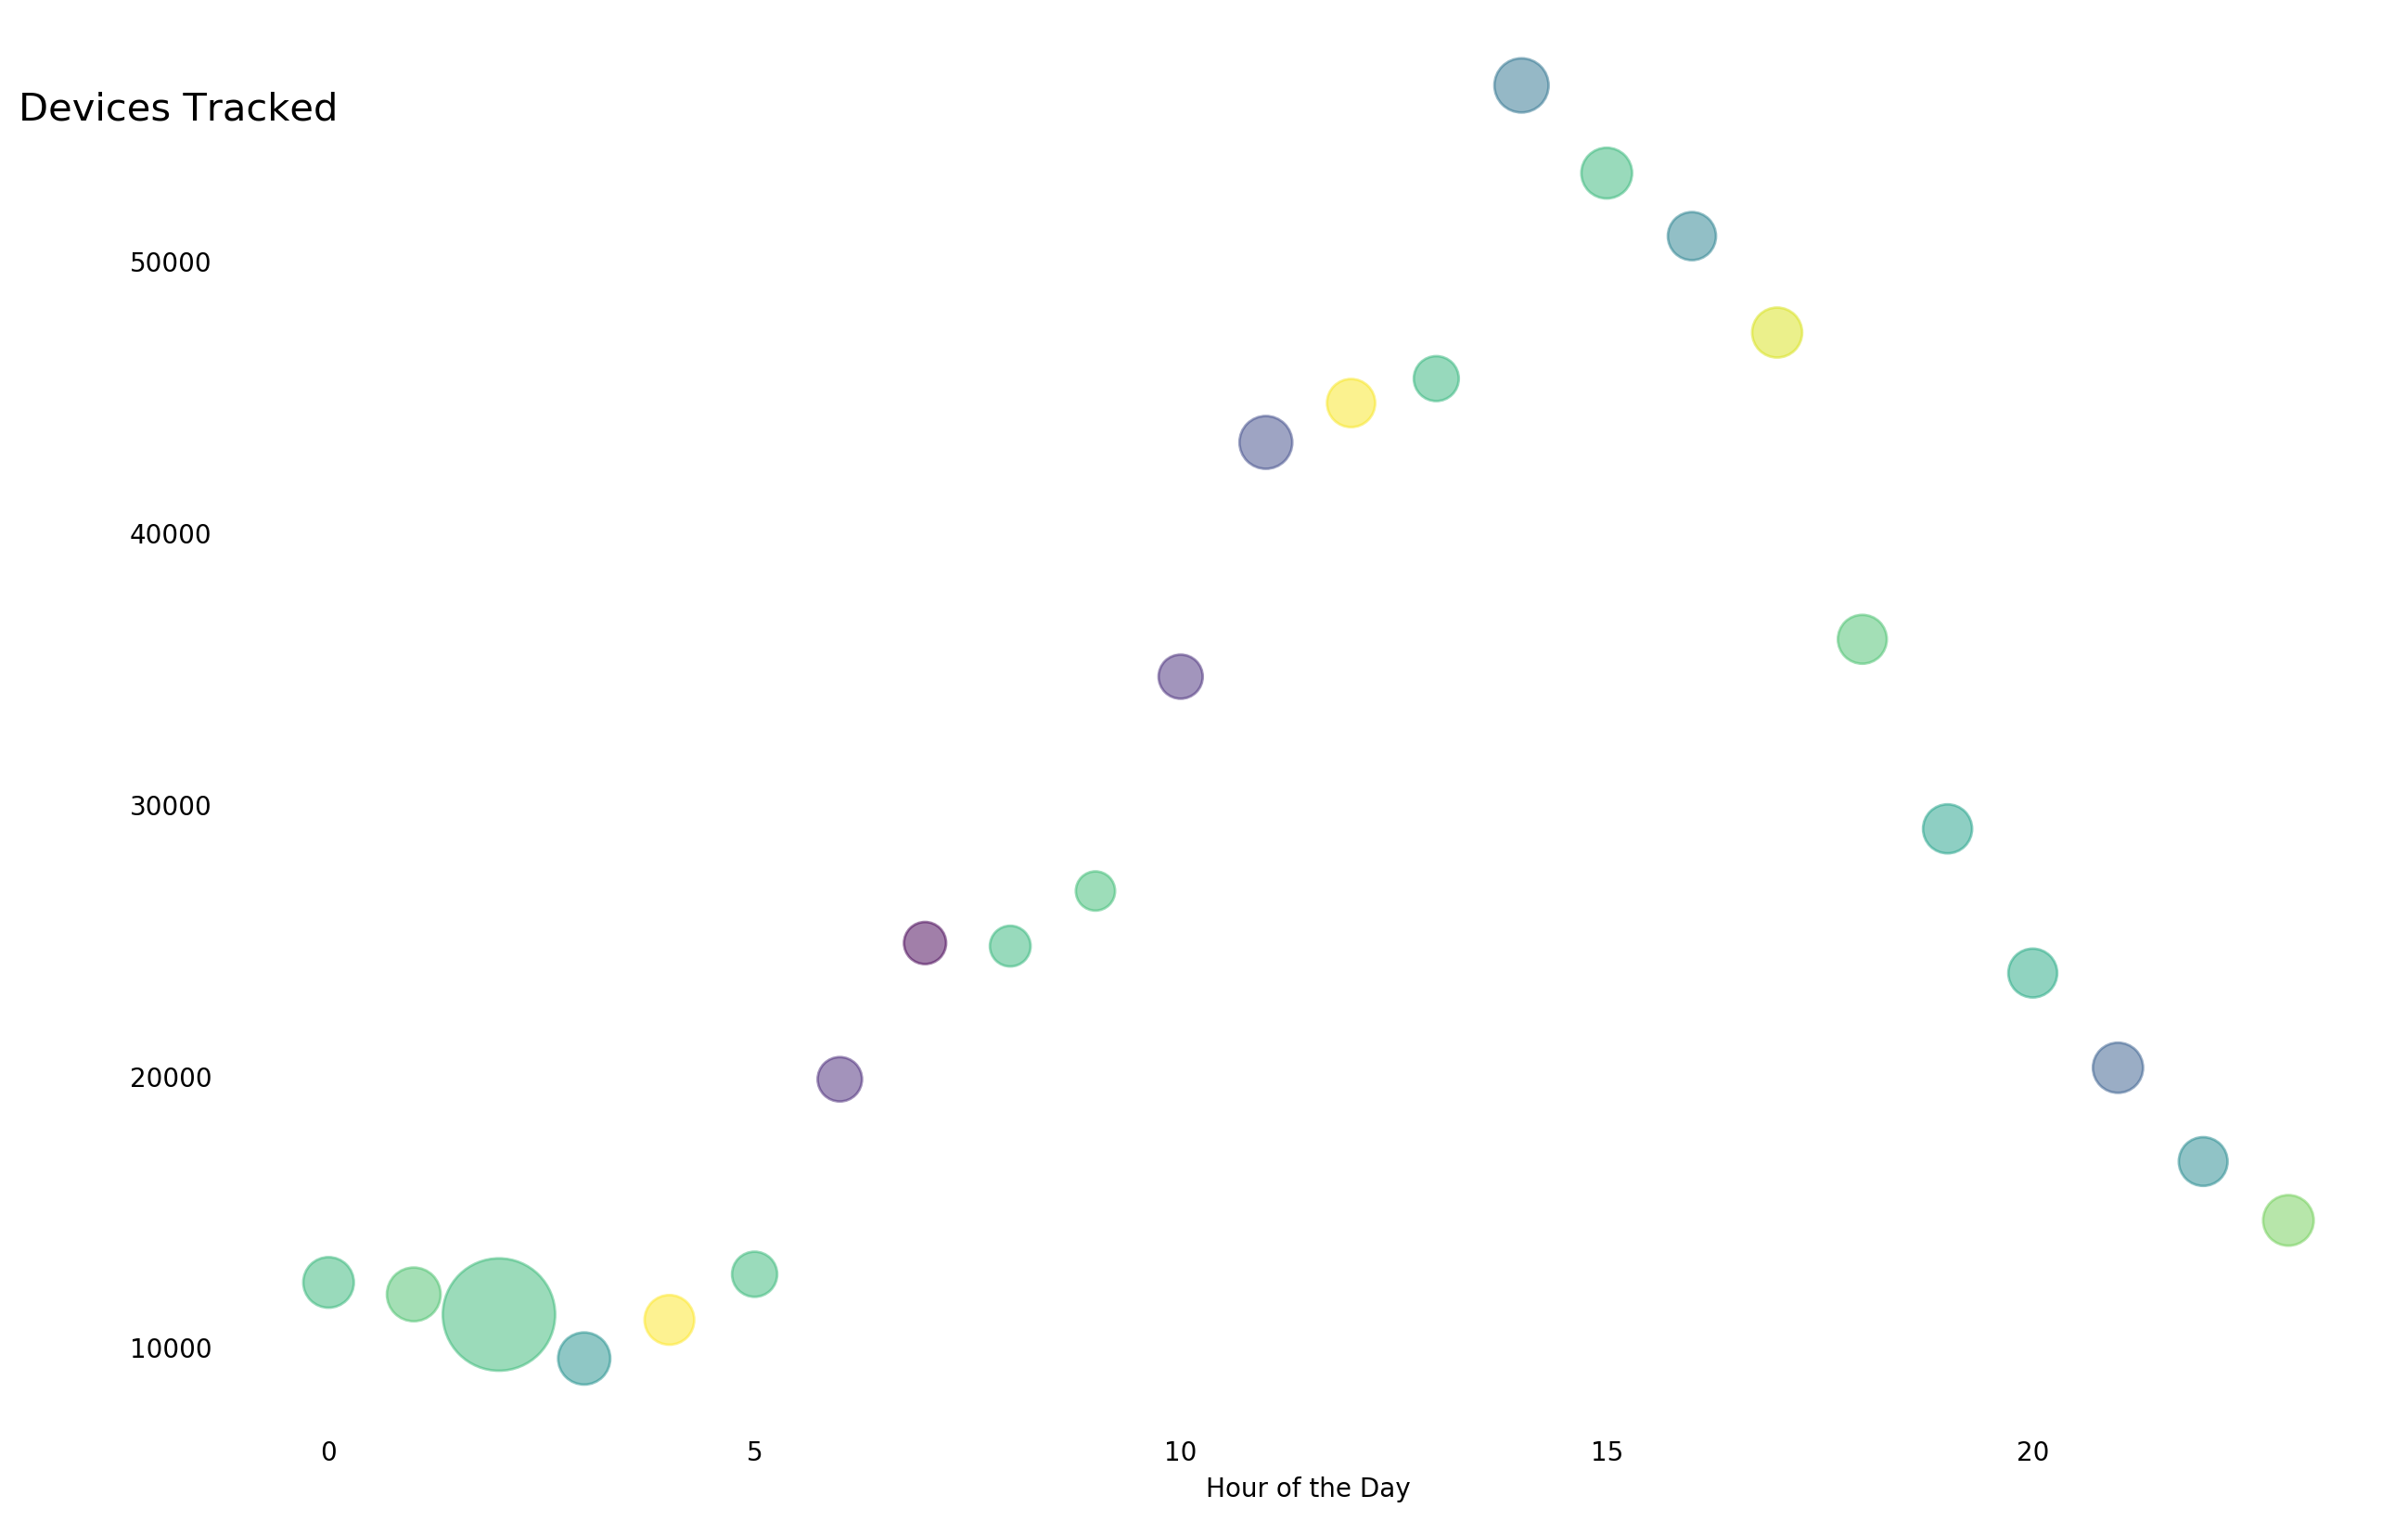

In [25]:
df_wifi_original = pd.read_csv('data/wifi.csv', sep=" ")
df_wifi = df_wifi_original
df_wifi['Timestamp'] = pd.to_datetime(df_wifi['Timestamp'].astype(int), unit='ms')

wifi_times = df_wifi['Timestamp']
wifi_grouped_sum = df_wifi.groupby([wifi_times.dt.hour]).sum()
np.random.seed(19680801)
x = wifi_grouped_sum.index
y = wifi_grouped_sum['DevicesTracked']
bubble_area = (wifi_grouped_sum['ApproxVerweildauerSek'] / 60)
colors = np.random.rand(24)

wifi_scatter = plt.scatter(x, y, s=bubble_area, c=colors, alpha=0.5)
# general layout
plt.xlabel('Hour of the Day')
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# put some text for y-label
plt.text(0.05,0.95, 'Devices Tracked', fontsize="15", ha="right", va="top", transform=plt.gca().transAxes)
# supress pyplot output
_ = plt.show

In [26]:
print('Median der Verweildauer in Stunden: ' + str(round(wifi_grouped_sum['ApproxVerweildauerSek'].median() / 60 / 60, 2)))
print('Verweildauer zwischen 2:00 und 2:59 Uhr in Stunden: ' + str(round(wifi_grouped_sum.loc[2, 'ApproxVerweildauerSek'] / 60 / 60)) + ' 😯')

Median der Verweildauer in Stunden: 6.02
Verweildauer zwischen 2:00 und 2:59 Uhr in Stunden: 32.0 😯
